# Using the Dimensions API to Explore UCSD Research

This notebook explores Dimensions, an API that contains information about research publications, grants, datasets and more. We are specifically interested in research done at UCSD and affliated groups. In this notebook, I explore which publishers are used and collaborations between UCSD and other universities. 

# Contents:
1. [An Overview of Using Dimcli to Access Dimensions Data](#overview)
2. [Retrieving the Data](#data)
3. [Publishers](#publishers)
4. [Topic Analysis](#topics)
5. [Datasets](#datasets)
6. [Affiliations and Collaborations](#collabs)

To start off with, I primarily use Dimcli, a Python client for accessing the Dimensions API, which helps authenticate into the API and handle query requests/responses.

In [2]:
# necessary imports
import dimcli
import pandas as pd
import numpy as np
import json

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px

In [4]:
# visualization settings
sns.set_style("white")
sns.set(rc={'figure.figsize':(12, 10)})

In [5]:
# get access with config file. resource: https://digital-science.github.io/dimcli/getting-started.html# 
dimcli.login()

Searching config file credentials for default 'live' instance..


Dimcli - Dimensions API Client (v1.3)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.10
Method: dsl.ini file


In [6]:
dsl = dimcli.Dsl()

# An Overview of Using Dimcli to Access Dimensions Data <a class="anchor" id="overview"></a>

One way to query data from the API is using the dimcli instance to make queries. You can specify different conditions, such as how many objects to return, time period to search, and where to search for the keyword.

In [11]:
# note: you can also use the data attribute to get JSON of info
dsl.query("search publications for \"library\" return publications limit 1")

Returned Publications: 1 (total = 11300136)
Time: 1.30s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


<dimcli.DslDataset object #2308410636384. Records: 1/11300136>

Another way to query information is to use Dimcli magic commands, created specifically for the Jupyter environment, that run faster. This specific command returns a pandas dataframe.

In [12]:
%%dsldf

search publications 
    for "machine learning"
return publications [title + research_orgs + research_org_names + times_cited + funders]
limit 5

Returned Publications: 5 (total = 5395317)
Time: 1.19s


title  \
0  Recent advances in the use of machine learning...   
1  Prospects and Challenges of Using Machine Lear...   
2  Machine learning for small interfering RNAs: a...   
3  Screening dementia and predicting high dementi...   
4  Tackling the Antimicrobial Resistance “Pandemi...   

                                  research_org_names  \
0               [Ampel BioSolutions (United States)]   
1  [King Abdulaziz City for Science and Technolog...   
2                             [Chung-Ang University]   
3                                  [Inje University]   
4  [Department of Pharmacy, University of Split S...   

                                       research_orgs  times_cited  \
0  [{'city_name': 'Charlottesville', 'country_cod...            2   
1  [{'acronym': 'EBSU ', 'city_name': 'Abakaliki'...           16   
2  [{'acronym': 'CAU', 'city_name': 'Seoul', 'cou...            4   
3  [{'city_name': 'Gimhae', 'country_code': 'KR',...            5   
4  [{'city_name': 'Split', 'country_code': 'HR', ...            0   

                                             funders  
0                                                NaN  
1  [{'acronym': 'KACST', 'city_name': 'Riyadh', '...  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [13]:
# all magic commands result stored in..
dsl_last_results.head()

title  \
0  Recent advances in the use of machine learning...   
1  Prospects and Challenges of Using Machine Lear...   
2  Machine learning for small interfering RNAs: a...   
3  Screening dementia and predicting high dementi...   
4  Tackling the Antimicrobial Resistance “Pandemi...   

                                  research_org_names  \
0               [Ampel BioSolutions (United States)]   
1  [King Abdulaziz City for Science and Technolog...   
2                             [Chung-Ang University]   
3                                  [Inje University]   
4  [Department of Pharmacy, University of Split S...   

                                       research_orgs  times_cited  \
0  [{'city_name': 'Charlottesville', 'country_cod...            2   
1  [{'acronym': 'EBSU ', 'city_name': 'Abakaliki'...           16   
2  [{'acronym': 'CAU', 'city_name': 'Seoul', 'cou...            4   
3  [{'city_name': 'Gimhae', 'country_code': 'KR',...            5   
4  [{'city_name': 'Split', 'country_code': 'HR', ...            0   

                                             funders  
0                                                NaN  
1  [{'acronym': 'KACST', 'city_name': 'Riyadh', '...  
2                                                NaN  
3                                                NaN  
4                                                NaN

# Retrieving the Data <a class="anchor" id="data"></a>

Let's start querying and build a pandas dataframe to do some exploratory data analysis on research done at UCSD. 

In [14]:
GRIDID_LIST = ["grid.266100.3"]
GRID_NAMES = ['University of California, San Diego'] # corresponds to the grid IDs
# other possible orgs -UC San Diego Health System, University of California San Diego Medical Center, Supercomputer Center

FIELDS = "title+type+year+journal+authors+research_orgs+research_org_names+publisher+times_cited+funders+authors_count+category_for"

In [15]:
# search publications from 2024
query = f"""search publications
            where research_orgs.id in {json.dumps(GRIDID_LIST)} and year=2024
            return publications[{FIELDS}] sort by year"""
result = dsl.query(query)

Returned Publications: 20 (total = 6563)
Time: 1.09s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


The above query only returns 20 publications out of 6563. However, to get a more accurate understanding of all publications from 2024 at UCSD, we could instead iteratively query over the Dimension records and get 300 records at a time, which avoids Dimension restrictions on number of queries that you can make.

In [16]:
result = dsl.query_iterative(query, limit=300)

Starting iteration with limit=300 skip=0 ...
0-300 / 6563 (6.26s)
300-600 / 6563 (4.47s)
600-900 / 6563 (6.59s)
900-1200 / 6466 (5.55s)
1200-1500 / 6563 (4.71s)
1500-1800 / 6563 (4.78s)
1800-2100 / 6563 (2.62s)
2100-2400 / 6563 (3.45s)
2400-2700 / 6563 (6.70s)
2700-3000 / 6563 (3.68s)
3000-3300 / 6563 (6.23s)
3300-3600 / 6563 (4.81s)
3600-3900 / 6563 (3.57s)
3900-4200 / 6563 (3.57s)
4200-4500 / 6563 (3.13s)
4500-4800 / 6563 (4.05s)
4800-5100 / 6563 (6.58s)
5100-5400 / 6563 (5.37s)
5400-5700 / 6563 (4.71s)
5700-6000 / 6563 (6.00s)
6000-6300 / 6563 (7.38s)
6300-6563 / 6563 (3.91s)
===
Records extracted: 6563
Warnings:  23


In [17]:
# turn result from Dimcli query into pandas dataframe
pubs = result.as_dataframe()
pubs.head()

title  \
0  The Effects of the COVID-19 Pandemic on Air Po...   
1  Emotional interference and attentional bias in...   
2  A Novel Prodrug Strategy Based on Reversibly D...   
3  Media Use and Its Associations With Paranoia i...   
4  Interface-guided phenotyping of coding variant...   

                                             authors  authors_count  \
0  [{'affiliations': [{'city': 'Tehran', 'city_id...             17   
1  [{'affiliations': [{'city': 'Warsaw', 'city_id...              7   
2  [{'affiliations': [{'city': 'Seoul', 'city_id'...             11   
3  [{'affiliations': [{'city': 'Montreal', 'city_...              6   
4  [{'affiliations': [{'city': 'San Diego', 'city...             12   

                                        category_for  \
0  [{'id': '80008', 'name': '37 Earth Sciences'},...   
1  [{'id': '80232', 'name': '5202 Biological Psyc...   
2  [{'id': '80005', 'name': '34 Chemical Sciences'}]   
3  [{'id': '80233', 'name': '5203 Clinical and He...   
4  [{'id': '80034', 'name': '3101 Biochemistry an...   

                         publisher  \
0       Bentham Science Publishers   
1             Akademiai Kiado Zrt.   
2  American Chemical Society (ACS)   
3                              NaN   
4                         Elsevier   

                                  research_org_names  \
0  [Department of Health Information Technology, ...   
1  [University of California, San Diego, Institut...   
2  [Chungnam National University, University of C...   
3  [The University of Texas at Dallas, University...   
4  [Munich Leukemia Laboratory (Germany), Univers...   

                                       research_orgs  times_cited     type  \
0  [{'acronym': 'SBMU', 'city_name': 'Tehran', 'c...            0  article   
1  [{'city_name': 'Warsaw', 'country_code': 'PL',...            0  article   
2  [{'acronym': 'UCSD', 'city_name': 'San Diego',...            0  article   
3  [{'acronym': 'JGH', 'city_name': 'Montreal', '...            0  article   
4  [{'acronym': 'UCSD', 'city_name': 'San Diego',...            0  article   

   year    journal.id                     journal.title  \
0  2024  jour.1389287                     Coronaviruses   
1  2024  jour.1047987  Journal of Behavioral Addictions   
2  2024  jour.1051962               ACS Central Science   
3  2024  jour.1051882                JMIR Mental Health   
4  2024  jour.1046010                      Cell Reports   

                                             funders  
0                                                NaN  
1  [{'acronym': 'NCN', 'city_name': 'Krakow', 'co...  
2  [{'acronym': 'NRF', 'city_name': 'Daejeon', 'c...  
3                                                NaN  
4  [{'acronym': 'NHGRI', 'city_name': 'Bethesda',...

In [18]:
pubs.shape

(6563, 13)

Next, I clean the data and reformat it to make it easier to work with. Specifically, I extract the funder name into a separate column and also extract the category names from dictionaries of information into lists with just the category name, as categorized by the Australian and New Zealand Standard Research Classification (ANZSRC).

In [19]:
# the funders information is given a list of dictionaries, each dictionary represents the info for a funder
# check if it's a float because some of the column values are NaN
pubs['funder_name'] = pubs['funders'].apply(lambda x : [] if isinstance(x, float)
                                            else [dict['name'] for dict in x])

In [20]:
# category_for format is a list of dictionaries, each dictionary containing the keys id and name
# only include broad categories from the ANZSRC, which have 2-digit codes 
pubs['overall_cat'] = pubs['category_for'].apply(lambda x : [] if isinstance(x, float)
                                                 else [dict['name'] for dict in x if not dict['name'][0:4].isdigit()])

# Publishers <a class="anchor" id="publishers"></a>

Let's explore which publishers are UCSD researchers publishing in, so we can compare to the current contracts the library has with publishers. Below, I create a simple dataframe and remove the publishers with less than ten publications to simplify our visualization.

In [21]:
# create dataframe to combine the publishers with only 1 publication into the group Other
count_publisher = pubs['publisher'].value_counts().reset_index()
other_num = count_publisher[count_publisher['count'] < 10]['publisher'].sum()
count_publisher = count_publisher[count_publisher['count'] >= 10] # delete publishers with <4 publications
# count_publisher.loc[len(count_publisher)] = ['Other', other_num] # add row for the Other
count_publisher.head()

publisher  count
0                       Elsevier   1407
1                Springer Nature    823
2                          Wiley    433
3  Cold Spring Harbor Laboratory    421
4  Oxford University Press (OUP)    316

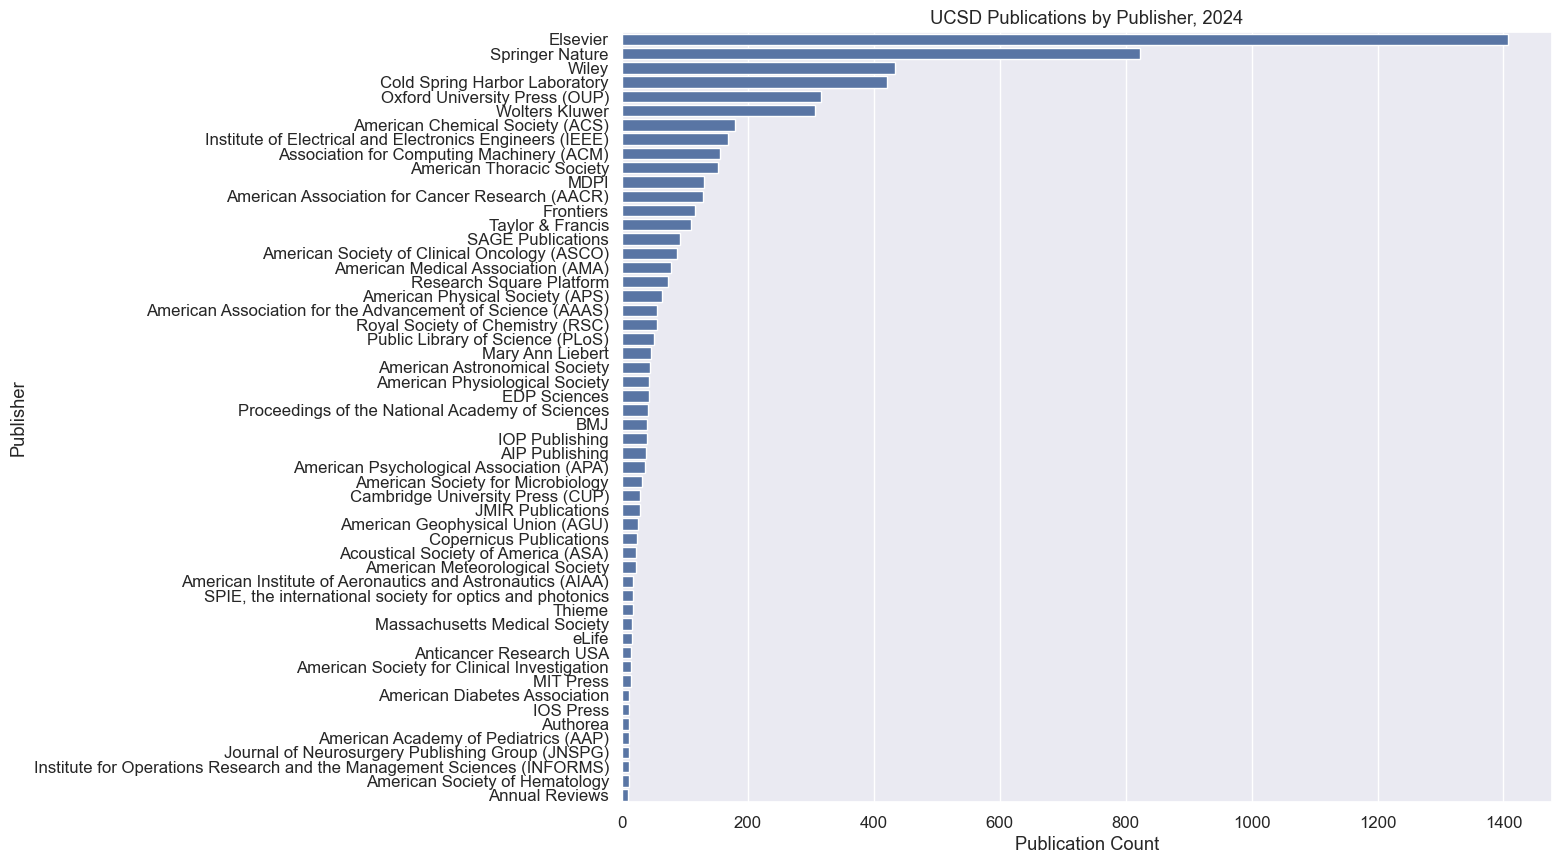

In [22]:
sns.set(font_scale=1.1)
sns.barplot(count_publisher, x="count", y="publisher")
plt.xlabel('Publication Count')
plt.ylabel('Publisher')
plt.title('UCSD Publications by Publisher, 2024')
plt.show()

Originally, I had a pie chart to visualize this information, but later switched to a bar graph, which displays a large number of publishers more clearly and allows viewers to more accurately gage how many publications there are in each category. 

I notice that the top publishers in 2024 are Elsevier, Springer Nature, and Wiley. Does this breakdown change based on domain? For example, do researchers in Biology publish in different places than researchers in the Computer Science department? 

To explore this question, I wrote a function to go through the publications and filter those in a specified category to look at their publishers specifically. I plot the top 10 publishers for the domain of Psychology, then save the figures for all domains for all 2-digit ANZSRC classifications into a pdf for more in-depth domain analysis.

In [23]:
# category: string representing category we want to visualize publishers for
# return: a dataframe, sorted descending
def createDomainDf(category):
    count_publisher = pd.DataFrame(columns=['publisher', 'count'])
    count_publisher = count_publisher.set_index('publisher')
    
    # loop through all publications and look at their list of categories
    for i in range(0, len(pubs)): 
        curr_cat = pubs['overall_cat'][i] # list of categories
        if category in curr_cat:
            if pubs['publisher'][i] in count_publisher.index.unique():
                count_publisher.loc[pubs['publisher'][i]] += 1
            else:
                count_publisher.loc[pubs['publisher'][i]] = 1

    return count_publisher.sort_values(by=['count'], ascending=False)

Here is a visualization of the top 10 publishers for UCSD publications in 2024 in the domain of psychology.

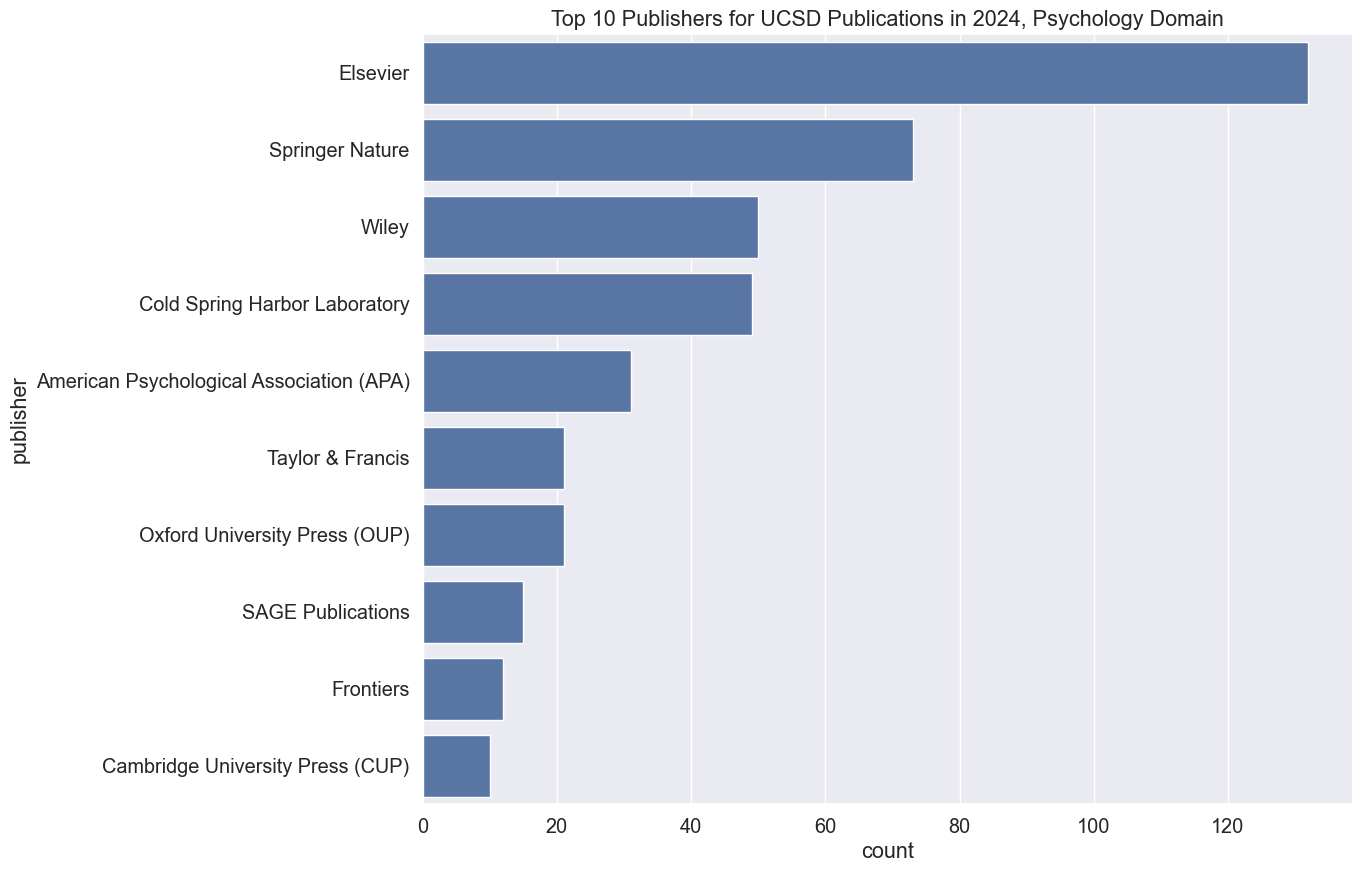

In [24]:
# example of one domain graph
sns.set(font_scale=1.3)
sns.barplot(x=createDomainDf('52 Psychology')['count'][0:10], y=createDomainDf('52 Psychology').index[0:10])
plt.title('Top 10 Publishers for UCSD Publications in 2024, Psychology Domain')
plt.show()

Now, for those that want a more comprehensive overview of the publishers for UCSD research broken down by domain, we save all the plots into a pdf.

In [25]:
# for loop over all categories and save figures into a pdf
# category: Indigenous Studies excluded, no publications in 2024 with that category
cat_list = ['30 Agricultural, Veterinary and Food Sciences',
       '31 Biological Sciences', '32 Biomedical and Clinical Sciences', '33 Built Environment and Design',
       '34 Chemical Sciences',
       '35 Commerce, Management, Tourism and Services', '36 Creative Arts and Writing',
       '37 Earth Sciences', '38 Economics', '39 Education',
       '40 Engineering', '41 Environmental Sciences',
       '42 Health Sciences', '43 History, Heritage and Archaeology',
       '44 Human Society','46 Information and Computing Sciences',
       '47 Language, Communication and Culture',
       '48 Law and Legal Studies', '49 Mathematical Sciences',
       '50 Philosophy and Religious Studies', '51 Physical Sciences',
       '52 Psychology']
figs = []
pdf = PdfPages('publishers_domain_graph.pdf') # output pdf

print('Creating figures...')
for cat in cat_list:
    print(cat)
    sns.set(font_scale=1)
    plt.figure(figsize=(8.5, 11))
    sns.barplot(x=createDomainDf(cat)['count'][0:10], y=createDomainDf(cat).index[0:10])
    plt.title('Top 10 Publishers for UCSD Publications in 2024, ' + cat + ' Domain')
    pdf.savefig(bbox_inches='tight')  # saves the current figure into a pdf page
    plt.close()

pdf.close()

Creating figures...
30 Agricultural, Veterinary and Food Sciences
31 Biological Sciences
32 Biomedical and Clinical Sciences
33 Built Environment and Design
34 Chemical Sciences
35 Commerce, Management, Tourism and Services
36 Creative Arts and Writing
37 Earth Sciences
38 Economics
39 Education
40 Engineering
41 Environmental Sciences
42 Health Sciences
43 History, Heritage and Archaeology
44 Human Society
46 Information and Computing Sciences
47 Language, Communication and Culture
48 Law and Legal Studies
49 Mathematical Sciences
50 Philosophy and Religious Studies
51 Physical Sciences
52 Psychology


Some points to note after looking at the PDF file of domain graphs are that:
- the domain Biomedical and Clinical Sciences has the most publications overall
- many of the top ten publishers in the domains include the big publishers Elsevier and Springer Nature
- some more niche domains, such as Earth Sciences and Chemical Sciences, have specific publishers that they used most in 2024 to publish their papers

# Topic Analysis <a class="anchor" id="topics"></a>

Another thing we can do with Dimensions data is do topic analysis. Topic Analysis is a natural language processing technique that allows us to extract topics and concepts from text and find patterns/meaning. 

For this section, I'll focus on one specific domain from the ANZSRC classification system, from UCSD research. I query information from Dimensions again specifically for this domain. There's also a great tutorial on this from Dimensions: <a href=https://api-lab.dimensions.ai/cookbooks/2-publications/Simple-topic-analysis.html>Topic Analysis<a>.

In [26]:
FOR = "38 Economics" 

query = f"""
search publications
    where research_orgs.id = "{GRIDID_LIST[0]}"
    and category_for.name= "{FOR}"
    and year=2024
    return publications[id+doi+concepts_scores+year]
"""

print("===\nQuery:\n", query)
print("===\nRetrieving Publications.. ")
data = dsl.query_iterative(query)

Starting iteration with limit=1000 skip=0 ...


===
Query:
 
search publications
    where research_orgs.id = "grid.266100.3"
    and category_for.name= "38 Economics"
    and year=2024
    return publications[id+doi+concepts_scores+year]

===
Retrieving Publications.. 


0-89 / 89 (1.15s)
===
Records extracted: 89


In [27]:
# process concept data
num_pubs = len(data)
concepts = data.as_dataframe_concepts() # turn concepts into df with one row per concept
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']] # process duplicates
concepts_unique

concept  frequency  score_avg
0                  homeowners insurance          1    0.78000
1                        winner's curse          1    0.77800
2             NBER working paper series          9    0.68344
3     residents of developing countries          9    0.68289
4                    pricing strategies          1    0.74100
...                                 ...        ...        ...
3741                    density testing          1    0.26800
3742                            package          1    0.25800
3744                         evaluation          1    0.24500
3746                   density analysis          1    0.19100
3747                               band          1    0.13700

[2305 rows x 3 columns]

In [28]:
concepts_unique['frequency']

0       1
1       1
2       9
3       9
4       1
       ..
3741    1
3742    1
3744    1
3746    1
3747    1
Name: frequency, Length: 2305, dtype: int64

In [29]:
# Figure out best parameters to define interesting and relevant concepts
# Frequency: how many documents include a concept (100 = no upper limit).
# Tip: concepts with very high frequencies tend to be common words, so it is useful to exclude them.
FREQ_MIN = 5
FREQ_MAX = 70
# Score: the average relevancy score of concepts, for the dataset we extracted above. good indicator of interesting concepts
SCORE_MIN = 0.4 
# Concepts to include in the visualization:
MAX_CONCEPTS = 200

if FREQ_MAX == 100:
  FREQ_MAX = 100000000

filtered_concepts = concepts_unique.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts,
           x="concept",
           y="frequency",
           height=700,
           color="score_avg",
           size="score_avg")

In [30]:
print('Total number of publications: ' + str(num_pubs))

Total number of publications: 89


Based on this plot, we have an idea of which concepts are occurring in higher frequency and which concepts are deemed more relevant with higher relevance scores and darker colors. I'm also curious about how these topics relate to each other, so let's build a concepts co-occurrence network, using the following Dimensions tutorial: <a href="https://api-lab.dimensions.ai/cookbooks/2-publications/Concepts-network-graph.html">Concepts Network Graph<a>.

In [31]:
concepts_net = data.as_dataframe() # previously queried data with concepts as lists for each publication
concepts_net.head()

id                                    concepts_scores  \
0  pub.1173460443  [{'concept': 'homeowners insurance', 'relevanc...   
1  pub.1173325221  [{'concept': 'human capital effects', 'relevan...   
2  pub.1173267053  [{'concept': 'network games', 'relevance': 0.7...   
3  pub.1173263420  [{'concept': 'health conditions of migrants', ...   
4  pub.1173251084  [{'concept': 'non-agricultural sectors', 'rele...   

                      doi  year  
0    10.2139/ssrn.4881204  2024  
1    10.1257/app.20220340  2024  
2  10.1093/cybsec/tyae009  2024  
3      10.1111/obes.12631  2024  
4      10.1093/ej/ueae056  2024

In [32]:
import networkx as nx
G = nx.Graph()

In [33]:
MIN_CONCEPT_SCORE = 0.6
MIN_CONCEPT_FREQUENCY = 4
MIN_CONCEPT_FREQUENCY = 4
MIN_EDGE_WEIGHT = 2

# Datasets <a class="anchor" id="datasets"></a>

At UCSD, where are people publishing datasets? 

In [34]:
#%dsldf search datasets for "machine learning" return datasets

# Affliations and Collaborations<a class="anchor" id="collabs"></a>

Let's find out which universities UCSD, and other affliated organizations like UCSD Health and UCSD Medical Center, are collaborating with on publications. We analyze these collaborations by looking at which research organizations are listed for each publication. 

In [35]:
# build df with geographical information and collaborations info
# includes collaborations with the 3 different UCSD related grid IDs
# loop through all research_orgs 
collabs = pd.DataFrame(columns=['lat', 'long', 'collabNum', 'type', 'countryCode', 'country'])
for orgs_list in pubs['research_orgs']:
    for org in orgs_list:
        if 'latitude' not in org or 'longitude' not in org: # if org doesn't have lat/long info, skip it
            print(org)
            continue
        if org['name'] in GRID_NAMES: # if org is UCSD related, skip
            continue
        if org['name'] not in collabs.index:
            collabs.loc[org['name']] = [org['latitude'], org['longitude'], 1, org['types'][0], org['country_code'], org['country_name']]
        else: # uni already in the dataframe
            collabs.at[org['name'], 'collabNum'] += 1

{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'na

Now, we use the dataframe we built to plot this information on a Plotly bubble map, with larger circles indicating more collaborations. 

In [36]:
fig = px.scatter_geo(collabs, lat='lat', lon='long', hover_name=collabs.index, size='collabNum', 
                     color='collabNum', color_continuous_scale="sunset_r")
fig.show()

We notice that the universities with the highest number of collaborations are mainly centered in the US and include Harvard, John Hopkins, UCSF, and Stanford. It also seems to correspond with highly population densities in the US. 

In [37]:
newdf = collabs.groupby(['countryCode', 'country'], as_index=False).sum()
newdf = newdf.drop(index=120)

In [38]:
fig = px.choropleth(newdf, locations="country", locationmode='country names',
                    color="collabNum",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

We notice that some lists of research orgs are quite long. We look at why this is by creating a visualization for number of research_org_names versus number of authors. 

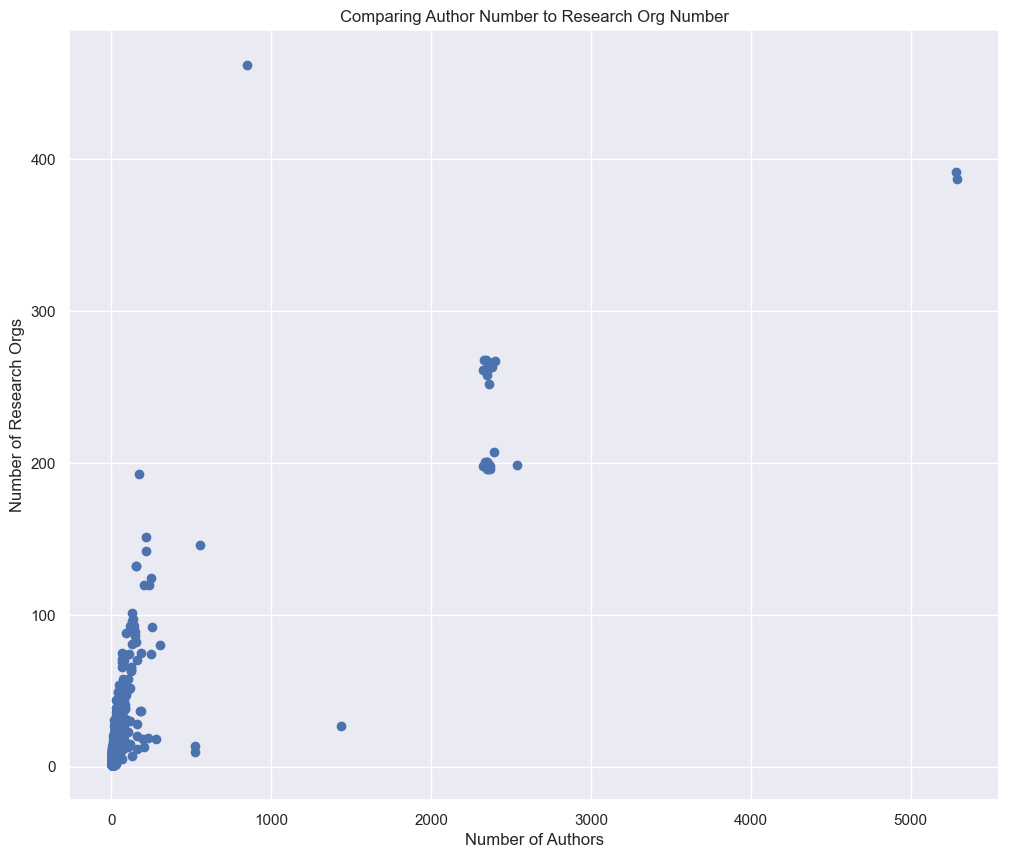

In [39]:
plt.scatter(pubs['authors_count'], pubs['research_org_names'].apply(lambda ls : len(ls)))
plt.xlabel('Number of Authors')
plt.ylabel('Number of Research Orgs')
plt.title('Comparing Author Number to Research Org Number')
plt.show()

We notice that there is a very general trend of number of research orgs increasing when number of authors increase. We can guess that this is because the authors might be affliated with different research organizations. Furthermore, we notice that astonishingly, some publications have more than 1000 authors.

In [40]:
len(pubs[pubs['authors_count'] > 1000])

35

# Work with RAGs

In [41]:
RAG_FIELDS = "title+abstract+year+journal+authors+research_org_names+publisher+times_cited+funders+category_for"

query = f"""search publications
            where research_orgs.id in {json.dumps(GRIDID_LIST)} and year=2024
            return publications[{RAG_FIELDS}] sort by year"""
result = dsl.query_iterative(query, limit=300)

Starting iteration with limit=300 skip=0 ...
0-300 / 6563 (5.58s)
300-600 / 6563 (4.98s)
600-900 / 6563 (4.71s)
900-1200 / 6466 (6.67s)
1200-1500 / 6563 (3.86s)
1500-1800 / 6563 (5.79s)
1800-2100 / 6563 (3.88s)
2100-2400 / 6563 (3.43s)
2400-2700 / 6563 (4.32s)
2700-3000 / 6563 (5.84s)
3000-3300 / 6563 (5.34s)
3300-3600 / 6563 (3.58s)
3600-3900 / 6563 (6.71s)
3900-4200 / 6563 (4.42s)
4200-4500 / 6563 (4.09s)
4500-4800 / 6563 (4.02s)
4800-5100 / 6563 (4.71s)
5100-5400 / 6563 (4.39s)
5400-5700 / 6563 (8.00s)
5700-6000 / 6563 (5.67s)
6000-6300 / 6563 (7.37s)
6300-6563 / 6563 (3.77s)
===
Records extracted: 6563
Warnings:  23


In [42]:
pubs = result.as_dataframe()
pubs.head()

title  \
0  The Effects of the COVID-19 Pandemic on Air Po...   
1  Emotional interference and attentional bias in...   
2  A Novel Prodrug Strategy Based on Reversibly D...   
3  Media Use and Its Associations With Paranoia i...   
4  Interface-guided phenotyping of coding variant...   

                                            abstract  \
0   Introduction: The efforts to reduce COVID-19 ...   
1  Abstract  Background and aims Despite the incl...   
2                                                NaN   
3  Background: Paranoia is a spectrum of fear-rel...   
4  Single-gene missense mutations remain challeng...   

                                             authors  \
0  [{'affiliations': [{'city': 'Tehran', 'city_id...   
1  [{'affiliations': [{'city': 'Warsaw', 'city_id...   
2  [{'affiliations': [{'city': 'Seoul', 'city_id'...   
3  [{'affiliations': [{'city': 'Montreal', 'city_...   
4  [{'affiliations': [{'city': 'San Diego', 'city...   

                                        category_for  \
0  [{'id': '80008', 'name': '37 Earth Sciences'},...   
1  [{'id': '80232', 'name': '5202 Biological Psyc...   
2  [{'id': '80005', 'name': '34 Chemical Sciences'}]   
3  [{'id': '80233', 'name': '5203 Clinical and He...   
4  [{'id': '80034', 'name': '3101 Biochemistry an...   

                         publisher  \
0       Bentham Science Publishers   
1             Akademiai Kiado Zrt.   
2  American Chemical Society (ACS)   
3                              NaN   
4                         Elsevier   

                                  research_org_names  times_cited  year  \
0  [Department of Health Information Technology, ...            0  2024   
1  [University of California, San Diego, Institut...            0  2024   
2  [Chungnam National University, University of C...            0  2024   
3  [The University of Texas at Dallas, University...            0  2024   
4  [Munich Leukemia Laboratory (Germany), Univers...            0  2024   

     journal.id                     journal.title  \
0  jour.1389287                     Coronaviruses   
1  jour.1047987  Journal of Behavioral Addictions   
2  jour.1051962               ACS Central Science   
3  jour.1051882                JMIR Mental Health   
4  jour.1046010                      Cell Reports   

                                             funders  authors_count  
0                                                NaN            NaN  
1  [{'acronym': 'NCN', 'city_name': 'Krakow', 'co...            NaN  
2  [{'acronym': 'NRF', 'city_name': 'Daejeon', 'c...            NaN  
3                                                NaN            NaN  
4  [{'acronym': 'NHGRI', 'city_name': 'Bethesda',...            NaN

In [43]:
pubs.to_csv('publication_docs.csv', index=False)  

In [44]:
# GET /schema
tables.render_schema()

NameError: name 'tables' is not defined

In [ ]:
# GET /data
tables.render_data(REQUEST)